# Extract lineage information from Goo simulations, and plot the hierarchy

In [206]:
# general packages
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os 
import json
import cv2
import re

# specific packages
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.pyplot import xticks
from scipy.optimize import curve_fit
import matplotlib.ticker as tck
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
from scipy.spatial.distance import euclidean
import networkx as nx

# set working directory
os.chdir("/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/")

font_props = {'family': 'Myriad Pro', 'size': 11}
font_props_text = {'family': 'Myriad Pro', 'size': 9}
title_font = FontProperties(family='Myriad Pro', size=11)


# colorblind-friendly colors
CB_palette = ['', '#f781bf', '#984ea3']

# set style
#sns.set_style("white")

In [148]:
# load data
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20231218_division_2xtargetvolume-based_1-500/20231218_division_2xtargetvolume-based_volumes.json", 'r') as f1:
    volumes1 = json.load(f1)

In [114]:
# Assuming volumes1 is a dictionary
cell_names = list(volumes1.keys())  # Converting keys to an array
print(f"Number of cells: {len(cell_names)}")

Number of cells: 101


In [117]:
def create_hierarchy(cell_names):
    hierarchy = {}

    for name in cell_names:
        parts = name.split('.')  # Split the cell name into parts
        current_level = hierarchy

        for part in parts:
            if part not in current_level:
                current_level[part] = {}  # Create a new level in the hierarchy
            current_level = current_level[part]  # Move to the next level

    return hierarchy


def complete_hierarchy(hierarchy, prefix=""):
    complete = {}
    for key, value in hierarchy.items():
        full_key = prefix + "." + key if prefix else key
        complete[full_key] = complete_hierarchy(value, full_key) if value else {}
    return complete


nested_hierarchy = create_hierarchy(cell_names)
complete_nested_hierarchy = complete_hierarchy(nested_hierarchy)
print(complete_nested_hierarchy)



{'cell_A1': {'cell_A1.002': {'cell_A1.002.002': {'cell_A1.002.002.002': {'cell_A1.002.002.002.002': {'cell_A1.002.002.002.002.002': {'cell_A1.002.002.002.002.002.002': {}, 'cell_A1.002.002.002.002.002.001': {}}, 'cell_A1.002.002.002.002.001': {'cell_A1.002.002.002.002.001.002': {}, 'cell_A1.002.002.002.002.001.001': {}}}, 'cell_A1.002.002.002.001': {'cell_A1.002.002.002.001.002': {'cell_A1.002.002.002.001.002.002': {}, 'cell_A1.002.002.002.001.002.001': {}}, 'cell_A1.002.002.002.001.001': {'cell_A1.002.002.002.001.001.002': {}, 'cell_A1.002.002.002.001.001.001': {}}}}, 'cell_A1.002.002.001': {'cell_A1.002.002.001.002': {'cell_A1.002.002.001.002.002': {'cell_A1.002.002.001.002.002.002': {}, 'cell_A1.002.002.001.002.002.001': {}}, 'cell_A1.002.002.001.002.001': {'cell_A1.002.002.001.002.001.002': {}, 'cell_A1.002.002.001.002.001.001': {}}}, 'cell_A1.002.002.001.001': {'cell_A1.002.002.001.001.002': {}, 'cell_A1.002.002.001.001.001': {}}}}, 'cell_A1.002.001': {'cell_A1.002.001.002': {'cel

Number of cells: 101


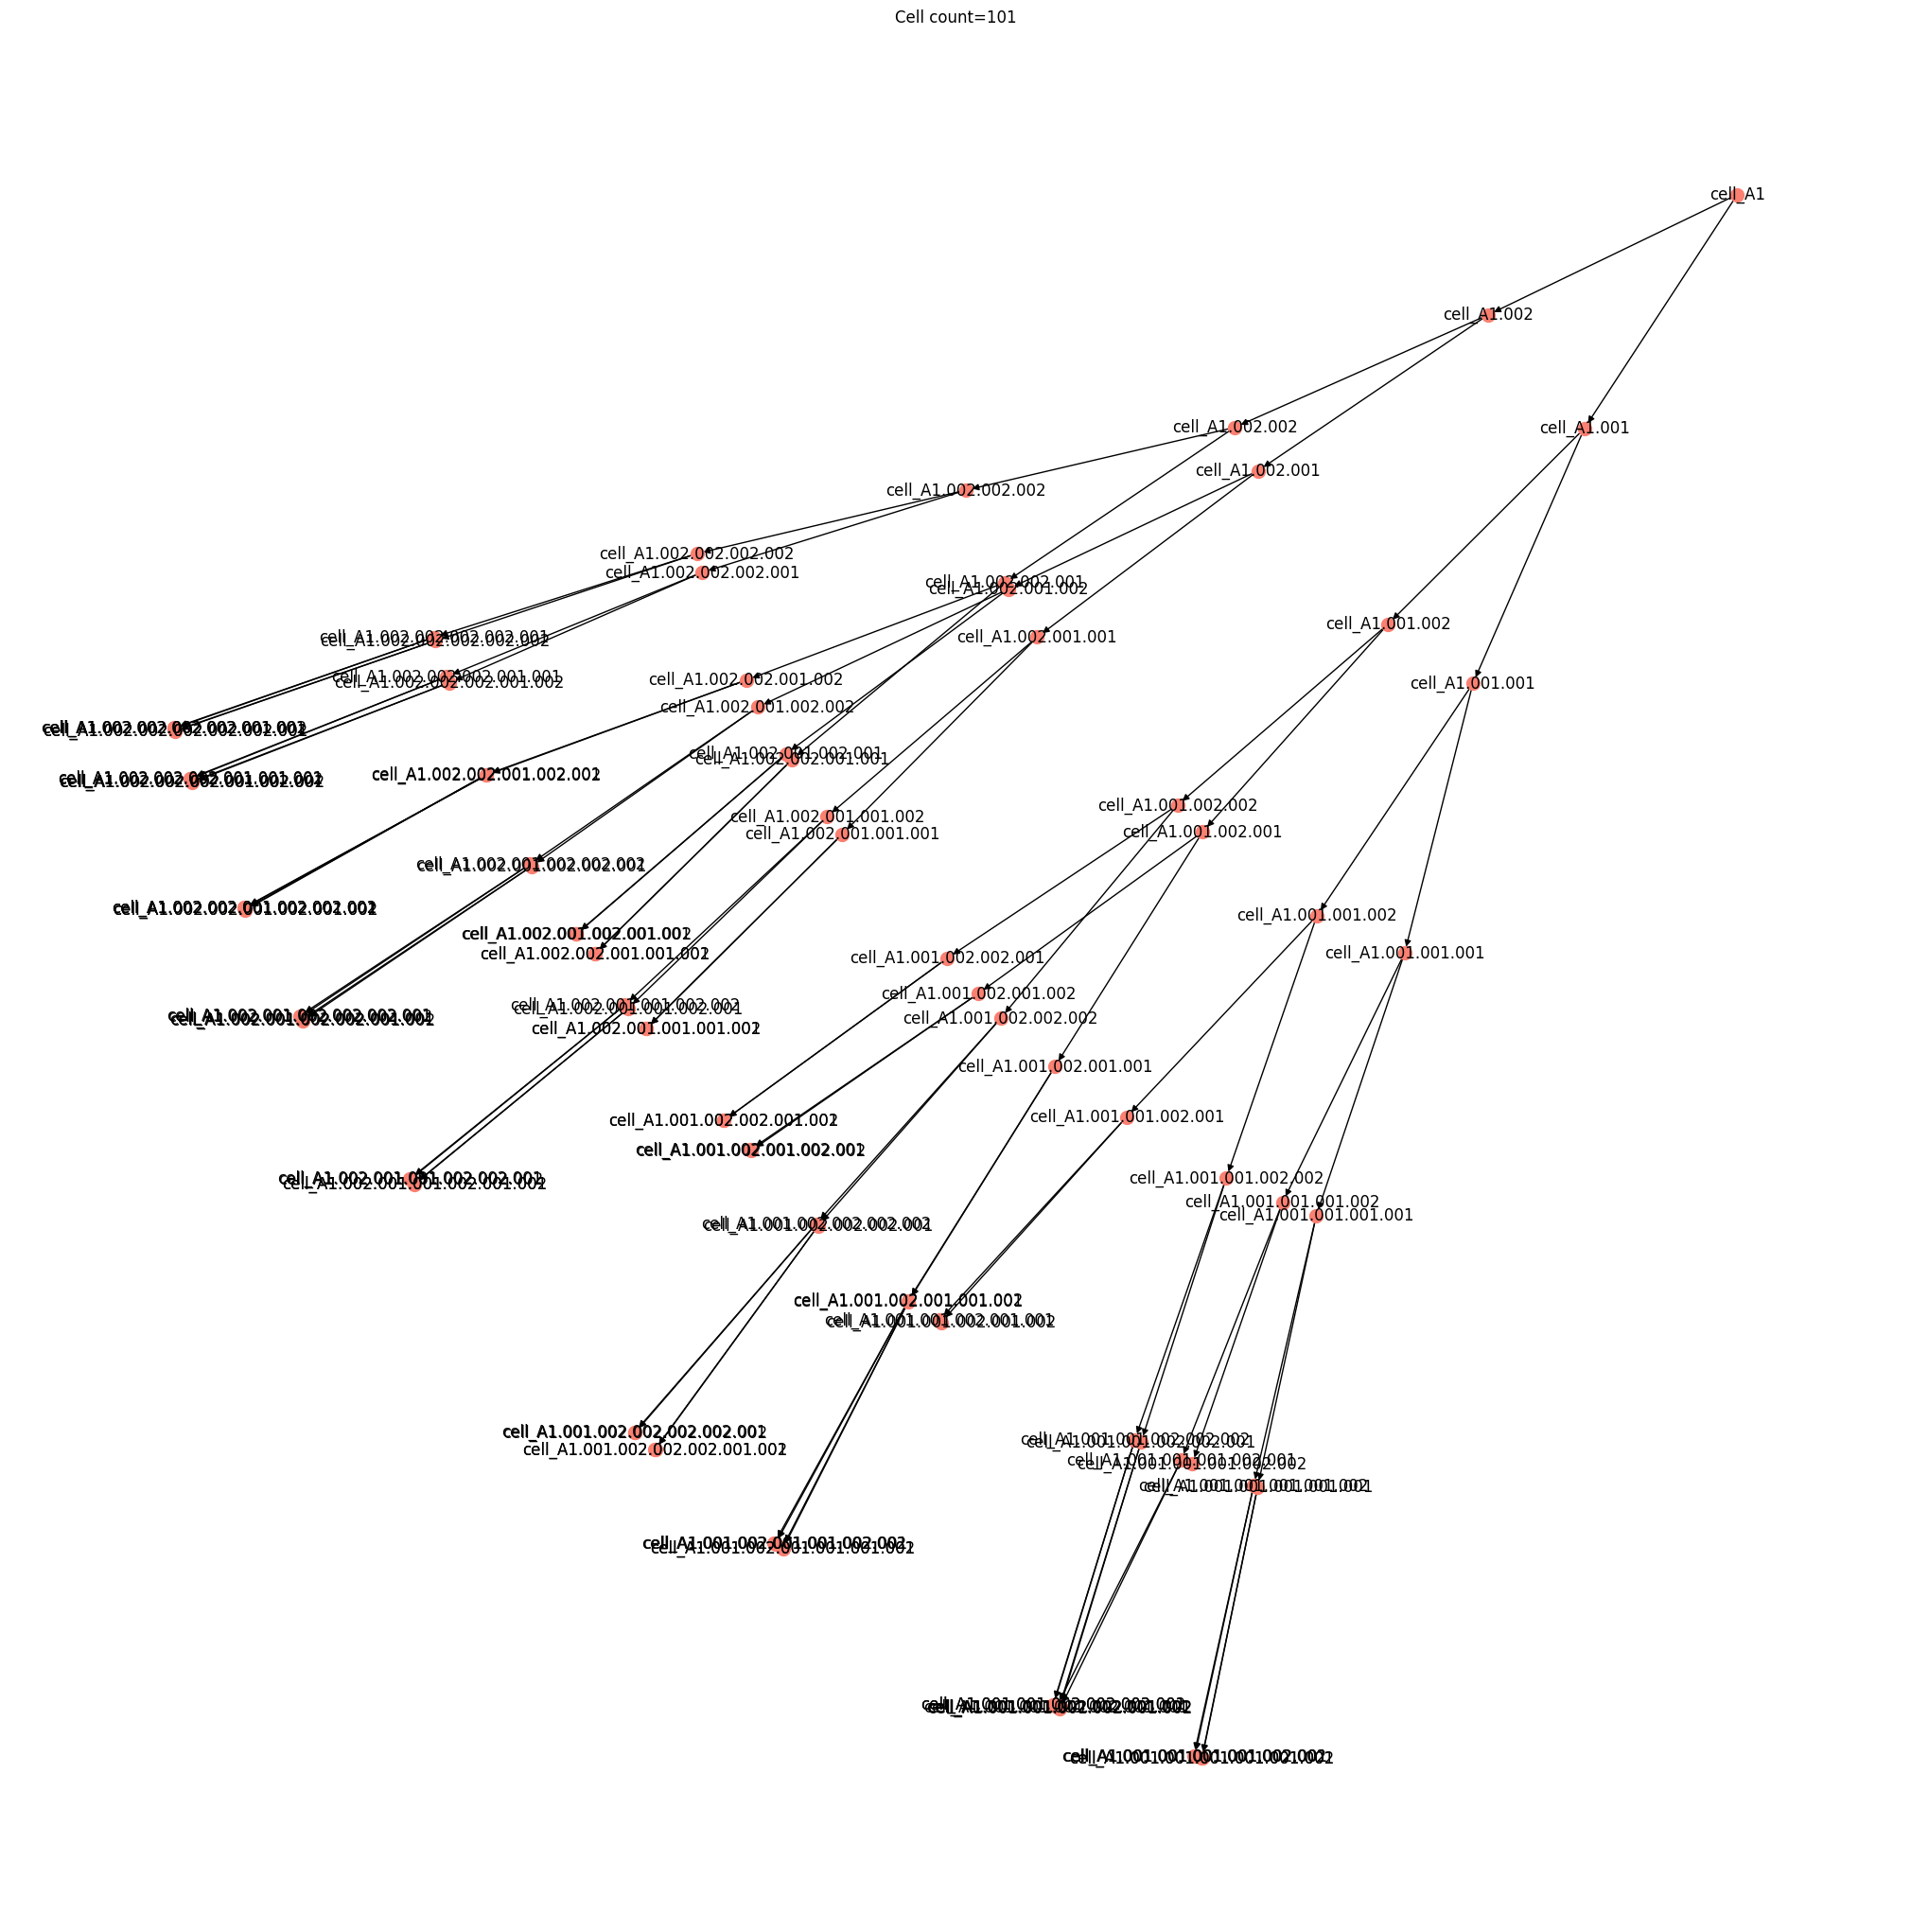

In [128]:
cell_names = list(volumes1.keys())  # Converting keys to an array
print(f"Number of cells: {len(cell_names)}")

def create_graph(hierarchy, parent=None):
    G = nx.DiGraph()
    for key, value in hierarchy.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            G_sub = create_graph(value, key)
            G = nx.compose(G, G_sub)
    return G

# Create the graph from the hierarchy
G = create_graph(complete_nested_hierarchy)

# Plot the lineage tree with increased node spacing
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G, dim=2)  # Adjusting the scale for increased spacing
nx.draw(G, pos, with_labels=True, node_size=100, node_color='salmon', font_size=12, arrows=True)
plt.title(f"Cell count={len(cell_names)}")
plt.savefig("division_lineage_kamada_kawai_layour.png", transparent=False, dpi=500)

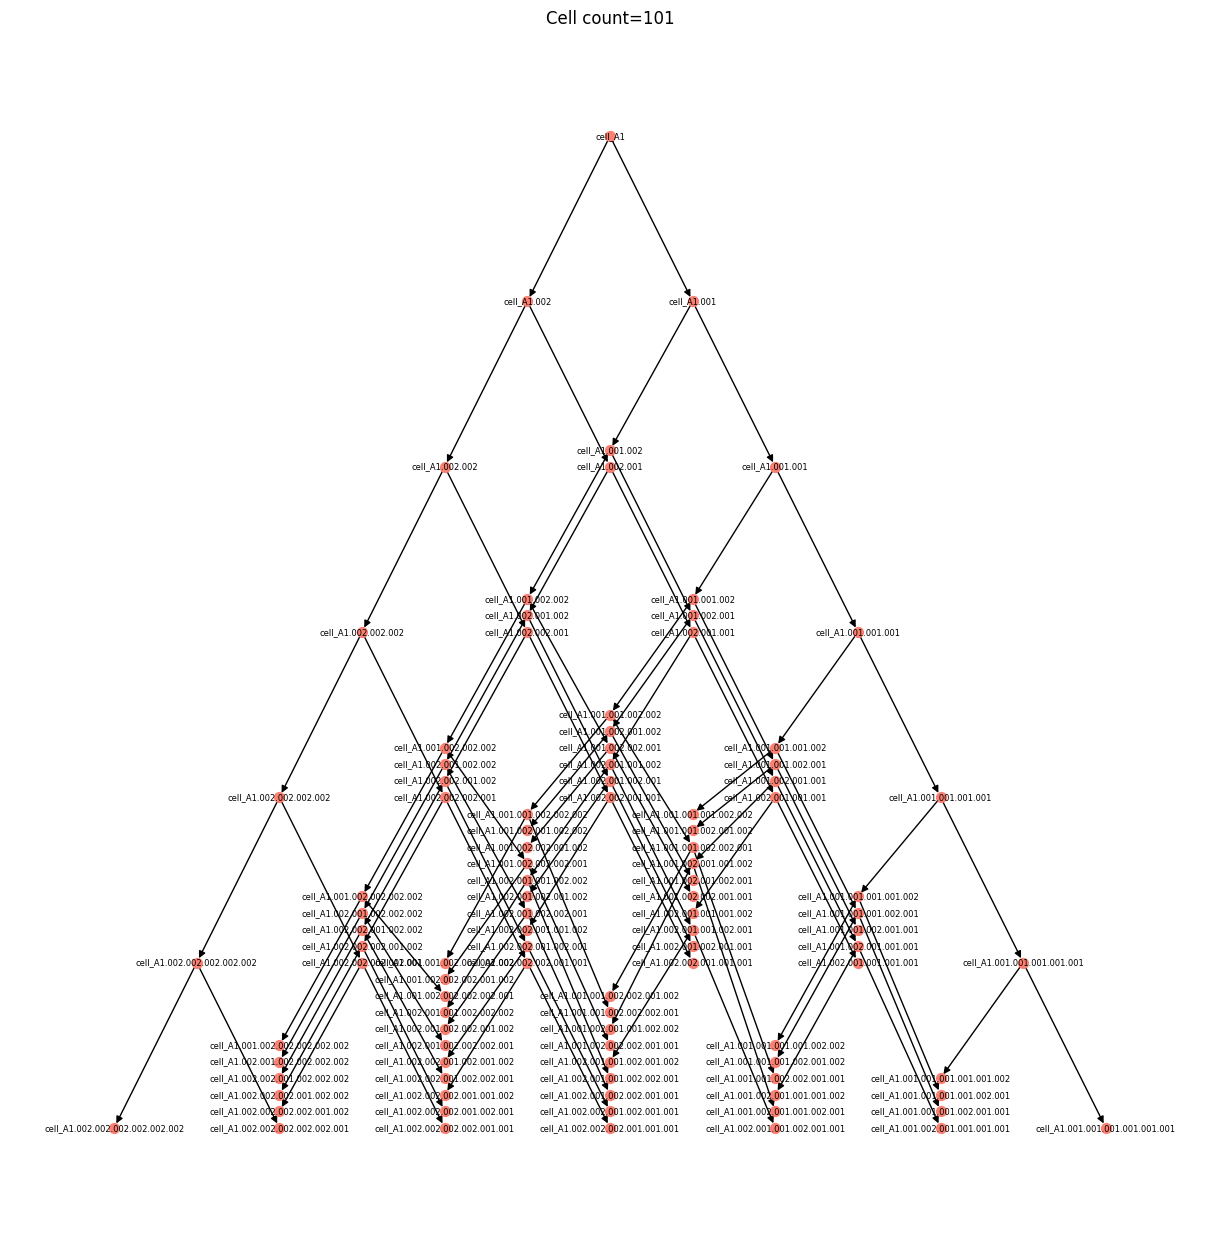

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(hierarchy, parent=None):
    G = nx.DiGraph()
    for key, value in hierarchy.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            G_sub = create_graph(value, key)
            G = nx.compose(G, G_sub)
    return G

# Create the graph from the hierarchy
G = create_graph(complete_nested_hierarchy)

# Calculate positions for nodes with adjusted height to avoid overlap
pos = {}
level_spacing = 100  # Adjust the spacing between levels
node_height = 10  # Adjust the node height to avoid overlap

def set_positions(node, level, x_offset, used_x):
    children = list(G.successors(node))
    num_children = len(children)
    if num_children > 0:
        x = x_offset - (num_children - 1) * level_spacing / 2
        for child in children:
            y = -level * level_spacing
            while (x, y) in used_x:  # Check if coordinates are already taken
                y += node_height
            pos[child] = (x, y)
            used_x.add((x, y))
            set_positions(child, level + 1, x, used_x)
            x += level_spacing

root_node = list(G.nodes())[0]  # Assuming the first node is the root
pos[root_node] = (0, 0)
set_positions(root_node, 1, 0, set())

# Plot the lineage tree with calculated node positions and adjusted height
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='salmon', font_size=6, arrows=True)
plt.title(f"Cell count={len(cell_names)}")
plt.savefig("division_lineage_hierarchical.png", transparent=False, dpi=500)

findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro'

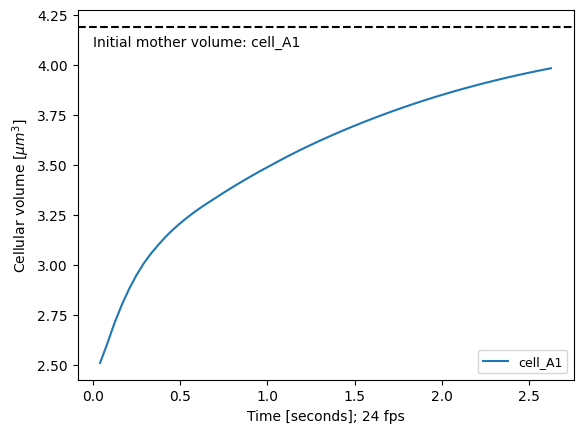

In [125]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Assume you have the functions create_hierarchy and complete_hierarchy defined as mentioned earlier

# Frame rate
fps = 24

# Generate hierarchy and volumes data here (assuming you have access to 'cell_names' and 'volumes1')
hierarchy = complete_hierarchy(create_hierarchy(cell_names))
division_times = {}

# Accumulate data for plotting on the same graph
def plot_volumes_over_time(cell_name, volumes, division_time):
    time_points = [(frame + 1) / fps + division_time for frame in range(len(volumes))]  # Convert frames to time
    plt.plot(time_points, volumes, label=cell_name)

# Traverse the hierarchy and plot volumes
def traverse_hierarchy(node, prefix="", division_time=0):
    if not node:
        return division_time

    for key, value in node.items():
        print(key)

        # Retrieve volumes data (replace this with your actual volumes retrieval method)
        volumes = volumes1.get(key, None)
        print(volumes)
        
        # If volumes data exists, plot volumes for this cell
        if volumes:
            print('volumes present')
            division_time = plot_volumes_over_time(key, volumes, division_time)
        
        # Recursively traverse the hierarchy
        division_time = traverse_hierarchy(value, key, division_time)
    
    return division_time

# Start traversal from the root of the hierarchy
traverse_hierarchy(complete_nested_hierarchy)

# Adding a horizontal line at y=4
plt.axhline(y=4.189, color='black', linestyle='--')
plt.text(0, 4.15, 'Initial mother volume: cell_A1', ha='left', va='top')

plt.xlabel('Time [seconds]; 24 fps')
plt.ylabel(r'Cellular volume $[\mu m^3]$')
plt.legend(prop=FontProperties(family='Myriad Pro', size=9))

# Save the plot
plt.savefig("hierarchy_volumes_plot.png", transparent=False, dpi=500)
plt.show()


findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro'

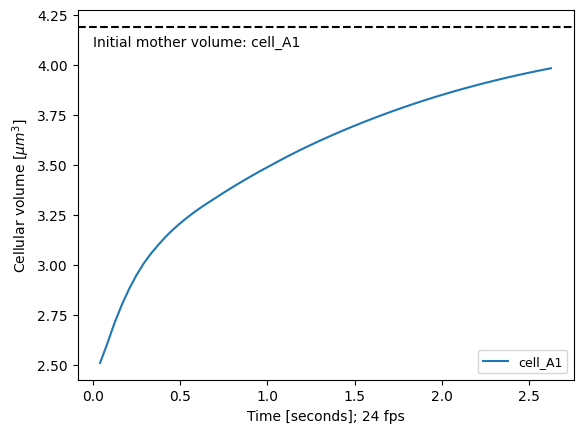

In [140]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Assume you have the functions create_hierarchy and complete_hierarchy defined as mentioned earlier

# Frame rate
fps = 24

# Generate hierarchy and volumes data here (assuming you have access to 'cell_names' and 'volumes1')
hierarchy = complete_hierarchy(create_hierarchy(cell_names))
division_times = {}

# Accumulate data for plotting on the same graph
def plot_volumes_over_time(cell_name, volumes, division_time):
    time_points = [(frame + 1) / fps + division_time for frame in range(len(volumes))]  # Convert frames to time
    plt.plot(time_points, volumes, label=cell_name)

# Traverse the hierarchy and plot volumes
def traverse_hierarchy(node, prefix="", division_time=0):
    if not node:
        return division_time

    for key, value in node.items():
        full_key = prefix + "." + key if prefix else key
        
        # Retrieve volumes data for the current cell or daughter cell
        volumes = volumes1.get(full_key, None)

        # Recursively traverse the hierarchy
        division_time = traverse_hierarchy(value, full_key, division_time)
        
        # If volumes data exists, plot volumes for this cell
        if volumes:
            plot_volumes_over_time(full_key, volumes, division_time)
    
    return division_time

# Start traversal from the root of the hierarchy
traverse_hierarchy(hierarchy)

# Adding a horizontal line at y=4
plt.axhline(y=4.189, color='black', linestyle='--')
plt.text(0, 4.15, 'Initial mother volume: cell_A1', ha='left', va='top')

plt.xlabel('Time [seconds]; 24 fps')
plt.ylabel(r'Cellular volume $[\mu m^3]$')
plt.legend(prop=FontProperties(family='Myriad Pro', size=9))

# Save the plot
plt.savefig("hierarchy_volumes_plot.png", transparent=False, dpi=500)
plt.show()


In [136]:
for key, value in volumes1.items(): 
    print(key)
    print(value)

cell_A1
[2.509427785652636, 2.606280410847405, 2.710068625176155, 2.8005365336954493, 2.8794029077161056, 2.947679948252191, 3.0066105861107033, 3.0560291816029395, 3.099064182230599, 3.139264449888593, 3.1750196726108895, 3.2070232061531194, 3.2364490459891213, 3.2642872509198844, 3.2896960174495704, 3.3137409256649555, 3.336864524529985, 3.360508182022547, 3.38307042510326, 3.405068478148674, 3.4266147820720723, 3.4475800013560334, 3.468128590571085, 3.4877328420386426, 3.507467746811564, 3.5269026373914003, 3.5458746309697573, 3.5642812557872805, 3.5821774024460082, 3.5995263071349717, 3.6164700204832774, 3.6329770037853595, 3.649130153250936, 3.6647746208976786, 3.6801035498364594, 3.695074914024098, 3.709757361733938, 3.7239861109468286, 3.7379379211467425, 3.75156143952794, 3.7648607098873494, 3.7778478441097816, 3.790485477257202, 3.8028182547544027, 3.8148958094742196, 3.826534922175375, 3.8379890350701, 3.8490145974710095, 3.8598007666356913, 3.8702914051248007, 3.880554386002

cell_A1
cell_A1.002
cell_A1.001
cell_A1.002.002
cell_A1.002.001
cell_A1.001.002
cell_A1.001.001
cell_A1.002.001.002
cell_A1.002.001.001
cell_A1.001.001.002
cell_A1.001.001.001
cell_A1.002.002.002
cell_A1.002.002.001
cell_A1.001.002.002
cell_A1.001.002.001
cell_A1.002.002.001.002
cell_A1.002.002.001.001
cell_A1.001.001.002.002
cell_A1.001.001.002.001
cell_A1.002.001.002.002
cell_A1.002.001.002.001
cell_A1.001.002.002.002
cell_A1.001.002.002.001
cell_A1.002.001.001.002
cell_A1.002.001.001.001
cell_A1.001.001.001.002
cell_A1.001.001.001.001
cell_A1.002.002.002.002
cell_A1.002.002.002.001
cell_A1.001.002.001.002
cell_A1.001.002.001.001
cell_A1.002.002.001.002.002
cell_A1.002.002.001.002.001
cell_A1.002.002.001.001.002
cell_A1.002.002.001.001.001
cell_A1.001.001.002.001.002
cell_A1.001.001.002.001.001
cell_A1.001.002.001.002.002
cell_A1.001.002.001.002.001
cell_A1.002.002.002.001.002
cell_A1.002.002.002.001.001
cell_A1.001.001.002.002.002
cell_A1.001.001.002.002.001
cell_A1.002.001.002.001.

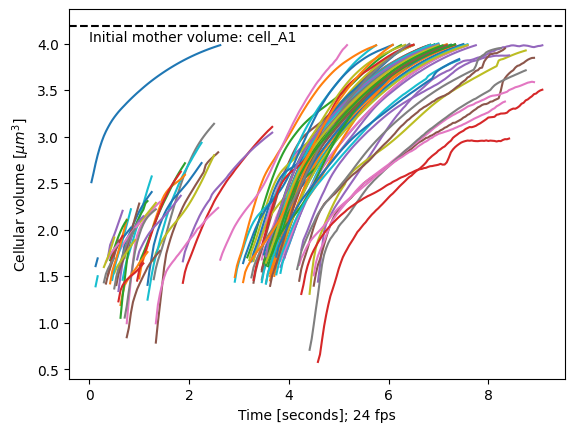

In [153]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Frame rate
fps = 24

# Example functions for creating hierarchy and completing it
# (These might be different based on your actual implementation)
def create_hierarchy(cell_names):
    hierarchy = {}
    for name in cell_names:
        parts = name.split('.')
        current_level = hierarchy
        for part in parts:
            if part not in current_level:
                current_level[part] = {}
            current_level = current_level[part]
    return hierarchy

def complete_hierarchy(hierarchy, prefix=""):
    complete = {}
    for key, value in hierarchy.items():
        full_key = prefix + "." + key if prefix else key
        complete[full_key] = complete_hierarchy(value, full_key) if value else {}
    return complete

# Generate hierarchy from cell names
cell_names = list(volumes1.keys())
hierarchy = complete_hierarchy(create_hierarchy(cell_names))

# Compute division times
division_times = {'cell_A1': 0}  # Assuming initial mother cell division at time 0
for cell_name, volumes in volumes1.items():
    if '.' in cell_name:
        mother_cell = cell_name.split('.')[0]
        if mother_cell in division_times:
            division_times[cell_name] = division_times[mother_cell] + len(volumes) / fps

# Plotting volumes over time with division time offsets
for cell_name, volumes in volumes1.items():
    offset = division_times.get(cell_name, 0)
    time_points = [(frame + 1) / fps + offset for frame in range(len(volumes))]
    plt.plot(time_points, volumes, label=cell_name)
    print(cell_name)

# Adding a horizontal line at y=4
plt.axhline(y=4.189, color='black', linestyle='--')
plt.text(0, 4.15, 'Initial mother volume: cell_A1', ha='left', va='top')

plt.xlabel('Time [seconds]; 24 fps')
plt.ylabel(r'Cellular volume $[\mu m^3]$')
#plt.legend(prop=FontProperties(family='Myriad Pro', size=9))

# Save the plot
plt.savefig("hierarchy_volumes_plot_with_offsets.png", transparent=False, dpi=500)
plt.show()


In [200]:
# load data
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240102_division_tests/test03_volumes.json", 'r') as f1:
    volumes_data = json.load(f1)
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240102_division_tests/test03_frame_cells.json", 'r') as f1:
    frame_data = json.load(f1)

In [201]:
print(len(volumes_data.get('cell_A1.01.01')))
print(len(frame_data.get('cell_A1.01.01')))

65
65


1


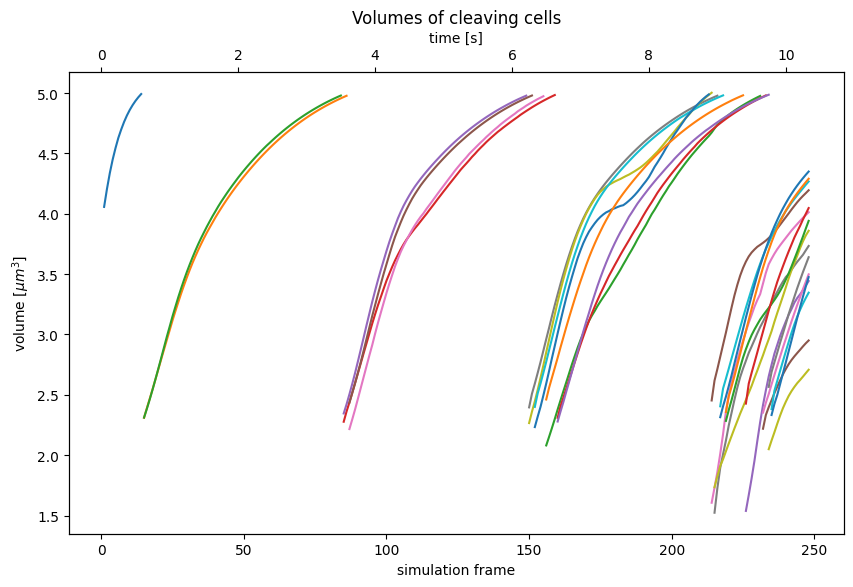

In [219]:
import matplotlib.pyplot as plt

# FPS (frames per second)
fps = 24

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twiny()  # Create a secondary x-axis

count = 0
for cell_name, volumes in volumes_data.items():
    frames = frame_data[cell_name]
    # Truncate frames if longer than volumes
    if len(frames) > len(volumes):
        frames = frames[:len(volumes)]
        count += 1

    # Convert frame numbers to time in seconds
    times = [frame / fps for frame in frames]

    ax1.plot(frames, volumes, label=cell_name)
    ax2.plot(times, volumes, alpha=0)  # Plotting on the secondary x-axis

print(count)

ax1.set_xlabel('simulation frame')
ax1.set_ylabel(r'volume [$\mu m^3$]')
ax2.set_xlabel(r'time [s]')

ax1.set_title('Volumes of cleaving cells')
# ax1.legend()  # Legend for the primary x-axis plot
#ax1.grid(True)

# Saving the plot
plt.savefig("volumes_frame_time.png", transparent=False, dpi=500)

plt.show()

